# Каскадные системы. Синтез управления методом бэкстеппинга

Рассмотрим задачу о стабилизации верхнего положения маятника.

Уравнения движения:

$$
m l^2 \ddot{\alpha} - m g l \sin{\alpha} = M_{\mathrm{упр}} \rightarrow
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + u
    \end{array}   
\right.
$$

Расмотрим управляющее воздействие вида
$$
u(\alpha,\omega) = k_1 \alpha + k_2 \sin{\alpha} + k_3 \omega.
$$

Для анализа устойчивости вертикального равновесия с выбранным законом управления рассмотрим функцию Ляпунова вида:
$$
    V(\alpha, \omega) = \frac{1}{2}(\alpha + \omega)^2 + \frac{1}{2}\omega^2.
$$

Вычислим производную V в силу вранений движения:
$$
\dot{V}(\alpha, \omega) = (\alpha+\omega)\omega + (\alpha + 2\omega)(\frac{g}{l}\sin{\alpha}+k_1 \alpha + k_2 \sin{\alpha} + k_3 \omega).
$$

Выберем коэффициенты $k_1, k_2, k_3$ так, чтобы обеспечить выполнение условия $\dot{V}<0$. Положим $k_2 = -g/l$:
$$
\dot{V}(\alpha, \omega) = k_1 \alpha^2 + (1 + 2 k_3) \omega^2 + (1 + 2k_1 + k_3)\alpha\omega.
$$

Положив $k_1 = -1/8$, $k_3 = -3/4$, получим
$$
\dot{V}(\alpha, \omega) = -\frac{1}{8}\alpha^2 - \frac{1}{2}\omega^2 < 0.
$$

Таким образом, закон управления:
$$
u(\alpha, \omega) = -\frac{1}{8}\alpha - \frac{g}{l}\sin{\alpha} -\frac{3}{4}\omega.
$$

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt

In [2]:
class Parameters(object):
    pass

param = Parameters()
param.g = 10
param.l = 1
param.gl = param.g / param.l

def control(x):
    return -x[0]/8 - param.gl * np.sin(x[0]) - 3/4 *  x[1]

def rhs(t, x):
    dxdt = np.zeros(2)
    
    dxdt[0] = x[1]
    dxdt[1] = param.gl * np.sin(x[0]) + control(x)
    
    return dxdt

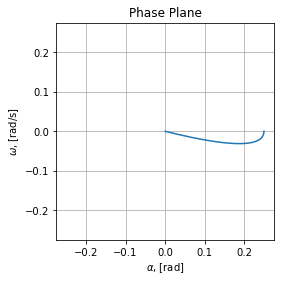

In [3]:
t0, tf, dt = 0, 100, 0.1
t_sol = np.arange(t0, tf, dt)

x0 = [0.25, 0]

sol = sci.solve_ivp(rhs, (t0, tf), x0, t_eval = t_sol)

x_sol = sol.y.T

pltlim = 1.1*max(max(x_sol[:,0]), max(x_sol[:,1]))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(-pltlim, pltlim)
plt.ylim(-pltlim, pltlim)
ax.plot(x_sol[:, 0], x_sol[:, 1])
ax.grid(True)
ax.set_title('Phase Plane')
ax.set_ylabel(r'$\omega$, [rad/s]')
ax.set_xlabel(r'$\alpha$, [rad]')
ax.set_aspect('equal')

Пусть теперь задача управления поставлена для динамической системы, описываемой системой дифференциальных уравнений
$$
\dot{x} = f(x,u,t),
$$

и пусть некоторой заменой переменных эта система приводится к виду:

$$
\begin{equation}\tag{1}
\left\{
    \begin{array}\\
       \dot{\eta} = f_0(\eta) + g_0(\eta)\xi_1, \\
       \dot{\xi}_1 = f_1(\eta, \xi_1) + g_1(\eta, \xi_1)\xi_2,\\
       \dot{\xi}_2 = f_2(\eta, \xi_1, \xi_2) + g_2(\eta, \xi_1, \xi_2)\xi_3,\\
       \vdots \\
       \dot{\xi}_{n-m} = f_{n-m}(\eta, \xi_1,..., \xi_{n-m}) + g_{n-m}(\eta, \xi_1,..., \xi_{n-m})u
    \end{array}   
\right. 
\end{equation}
$$

Таким образом, в новых переменных система принимает блочный нижне-треугольный вид, начинающийся с неприводимого блока, отвечающего переменным $\eta$.

Частным случаем такой системы, является система, включающая несколько последовательно включенных интеграторов
$$
\begin{equation}\tag{2}
\left\{
    \begin{array}\\
       \dot{\eta} = f_0(\eta) + g_0(\eta)\xi_1, \\
       \dot{\xi}_1 = \xi_2,\\
       \dot{\xi}_2 = \xi_3,\\
       \vdots \\
       \dot{\xi}_{n-m} = u
    \end{array}   
\right. 
\end{equation}
$$

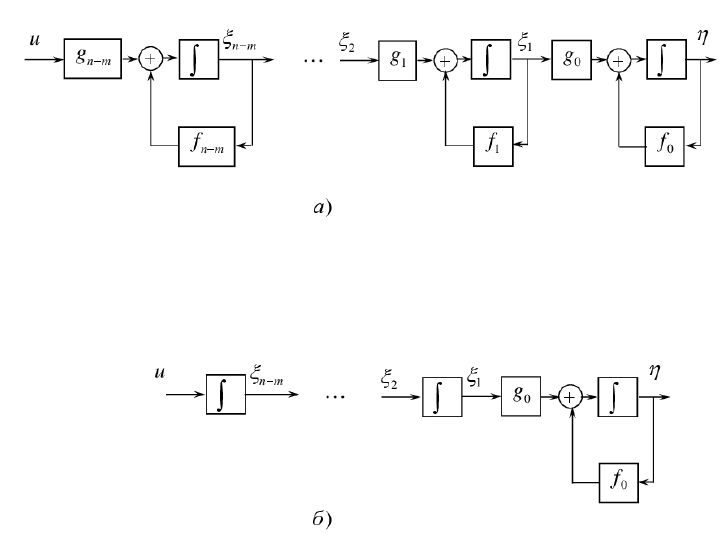

Благодаря рекурсивной структуре системы синтез управления можно начать со стабилизации первой неприводимой системы  в переменных $\eta$. Затем полученный закон управления последовательно наращивается включением в рассмотрение новых переменных $\xi_i$, при этом мы пошагово двигаемся по блоксхеме полной системы справа налево (то есть в обратном направлении), что и дало название методу - backstepping.

Схематично метод бэкстеппинга работает следующим образом:

1. Рассмотрим первую подсистему системы (1) в переменных $\eta$, взяв $\xi_1$ в качестве управления. Пусть эта система может быть стабилизирована с помощью закона управления $\xi_1 = \varphi_0(\eta)$, удовлетворяющего условию $\varphi_0(0)=0$, таким образом, что нулевое решение системы
$$
\begin{equation}\tag{3}
\dot{\eta} = f_0(\eta) + g_0(\eta)\varphi_0(\eta) 
\end{equation}
$$
асимптотически устойчиво. Кроме того, будем считать, что нам известна положительно определённая функция Ляпунова
$$
V_0(\eta): \quad  \quad \dot{V}_0 = \frac{\partial V_0}{\partial \eta}\dot{\eta} = W_0(\eta) <0
$$
в некоторой окрестности нуля.


2. Рассмотрим вторую подсистему системы (1) относительно переменной $\xi_1$, взяв в качестве управления $\xi_2$, и синтезируем закон управления $\xi_2 = \varphi_1(\eta, \xi_1)$, удовлетворяющий условию $\varphi_1(0,0) = 0$, таким образом, что система, состоящая из (1) и
$$
\dot{\xi}_1 = f_1(\eta, \xi_1) + g_1(\eta, \xi_1)\xi_2
$$
имеет асимптотически устойчивое нулевое решение, причём переменная $\xi_1$ повторяет закон управления $\varphi_0(\eta)$, синтезированный на предыдущем шаге. Для синтеза закона управления $\xi_2 = \varphi_1(\eta, \xi_1)$ используем функцию Ляпунова
$$
V_1(\eta, \xi_1) = V_1(\eta) + \frac{1}{2}\left(\xi_1 - \varphi_0(\eta)\right)^2
$$

Закон управления $\varphi_1(\eta, xi_1)$ выбираем такким образом, чтобы добиться отрицательной определённости производной
$$
\dot{V}_1 = \frac{\partial V_1}{\partial \eta} \dot{\eta} + \frac{\partial V_1}{\partial \xi_1} \dot{\xi_1} = W_1(\eta, \xi_1) <0
$$

3. Процесс пошагового синтеза управления продолжается до шага с номером $n-m$, на котором синтезируется закон управления $u$.


Можно показать, что для системы вида (2)  с одним интегратором, закон управления имеет вид:
$$
u(\eta, \xi) = \frac{\partial \varphi_0(\eta)}{\partial \eta} \left( f_0(\eta) + g_0(\eta) \xi\right) - \frac{\partial V_0(\eta)}{\partial \eta} g_0(\eta) - \lambda (\xi - \varphi(\eta)), \quad \lambda > 0
$$


Подробное обоснование метода см. например, в книге 
 Поляк Б.Т., Хлебников М.В., Рапопорт Л.Б. Математическая теория автоматического управления: учебное пособие. - М.: Ленанд, 2019.

## Пример

Вернёмся к примеру о стабилизации верхнего положения математического маятника. Пусть нужно стабилизировать верхнее положение математического маятника при помощи рулевой машинки. Будем считать, что уравнения описывающие мащинку можно представить в виде двойного интегратора.

обозначив через $\alpha$ отклонение от вертикали и через $\omega$ угловую скорость, запишем:
$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = \xi_2, \\
       \dot{\xi}_2 = u
    \end{array}   
\right.
$$

Синтез закона управления, стабилизирующего нулевое положение этой системы, разобъём на два шага в соответствии с описанной схемой. На первом шаге рассмотрим стабилизацию системы с одним интегратором:

$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = \xi_2
    \end{array}   
\right.
$$

и управлением $\xi_2$, для синтеза которого применим один шаг бэкстеппинга.

Из предыдущего примера для $\eta = (\alpha, \omega)$
$$
\varphi_0(\eta) = -\frac{1}{8}\alpha -\frac{g}{l}\sin{\alpha}-\frac{3}{4}\omega, \quad V_0(\eta) = \frac{1}{2}(\alpha + \omega)^2 + \frac{1}{2}\omega^2.
$$

При этом
$$
W_0(\eta) = -\frac{1}{8}\alpha^2 - \frac{1}{2}\omega^2. 
$$

In [51]:
def control_bck1(x):
    lmbda0  = 10
    
    a = (1 + lmbda0 / 8)
    b = (17/8 + 3 * lmbda0 / 4)
    c = (3/4 + lmbda0)
    
    ctrl = - a * x[0] -b * x[1] - c * param.gl * np.sin(x[0]) - param.gl * x[1] * np.cos(x[0]) - c * x[2]
    
    return ctrl

def rhs_bck1(t, x):
    dxdt = np.zeros(3)
    
    dxdt[0] = x[1]
    dxdt[1] = param.gl * np.sin(x[0]) + x[2]
    dxdt[2] = control_bck1(x)
        
    return dxdt

def control_bck2(x):
    lmbda0  = 10
    lmbda1 = 10
    
    a = (1 + lmbda0 / 8)
    b = (17 / 8 + 3 * lmbda0 / 4)
    c = (3 / 4 + lmbda0)
    e = x[2] + x[0] / 8 + param.gl * np.sin(x[0]) + 3 * x[1] / 4
    
    ctrl  = x[0] * x[1] + x[1]**2 + e * x[1] * (1/8 + param.gl * np.cos(x[0])) + \
            (x[0] + 2 * x[1] + 3 * e / 4) * (param.gl * np.sin(x[0]) + x[2]) + e * x[3] - e - \
            lmbda1 * (x[3] + a * x[0] + b * x[1] + c * param.gl * np.sin(x[0]) + param.gl * x[1] * np.cos(x[0]) + c * x[3])
    return ctrl

def rhs_bck2(t, x):
    dxdt = np.zeros(4)
    
    dxdt[0] = x[1]
    dxdt[1] = param.gl * np.sin(x[0]) + x[2]
    dxdt[2] = x[3]
    dxdt[3] = control_bck2(x)
    
    
    return dxdt

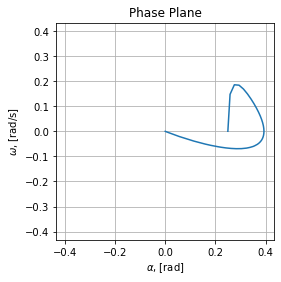

In [52]:
t0, tf, dt = 0, 20, 0.1
t_sol = np.arange(t0, tf, dt)

x0 = [0.25, 0, 0]

sol = sci.solve_ivp(rhs_bck1, (t0, tf), x0, t_eval = t_sol)

x_sol = sol.y.T

pltlim = 1.1*max(max(x_sol[:,0]), max(x_sol[:,1]))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(-pltlim, pltlim)
plt.ylim(-pltlim, pltlim)
ax.plot(x_sol[:, 0], x_sol[:, 1])
ax.grid(True)
ax.set_title('Phase Plane')
ax.set_ylabel(r'$\omega$, [rad/s]')
ax.set_xlabel(r'$\alpha$, [rad]')
ax.set_aspect('equal')